In [1]:
from google.cloud import bigquery
from google.cloud import aiplatform
import bigframes.pandas as bpd
import pandas as pd
from vertexai.language_models._language_models import TextGenerationModel
from vertexai.generative_models import GenerativeModel
from bigframes.ml.cluster import KMeans
from bigframes.ml.model_selection import train_test_split

In [2]:
project_id = 'qwiklabs-gcp-03-cdf24d924f64'
dataset_name = "shaunak_ecommerce"
model_name = "customer_segmentation_model"
table_name = "customer_stats"
location = "us-central1"
client = bigquery.Client(project=project_id)
aiplatform.init(project=project_id, location=location)

In [4]:
%%bigquery
CREATE OR REPLACE TABLE shaunak_ecommerce.customer_stats AS
SELECT
  user_id,
  DATE_DIFF(CURRENT_DATE(), CAST(MAX(order_created_date) AS DATE), day) AS days_since_last_order, ---RECENCY
  COUNT(order_id) AS count_orders, --FREQUENCY
  AVG(sale_price) AS average_spend --MONETARY
  FROM (
      SELECT
        user_id,
        order_id,
        sale_price,
        created_at AS order_created_date
        FROM `bigquery-public-data.thelook_ecommerce.order_items`
        WHERE
        created_at
            BETWEEN '2022-01-01' AND '2023-01-01'
  )
GROUP BY user_id;

Query is running:   0%|          |

""


In [5]:
# prompt: Convert the table shaunak_ecommerce.customer_stats to a bigframes dataframe and show the top 10 records

# Read the BigQuery table "qwiklabs-gcp-03-cdf24d924f64.shaunak_ecommerce.customer_stats" into a BigFrames DataFrame.
df = bpd.read_gbq("qwiklabs-gcp-03-cdf24d924f64.shaunak_ecommerce.customer_stats")

# Display the top 10 records of the DataFrame.
result = df.head(10)

In [6]:
bqdf = bpd.read_gbq(f"{project_id}.{dataset_name}.{table_name}")
bqdf.head(10)

/usr/local/lib/python3.11/dist-packages/bigframes/core/log_adapter.py:180: TimeTravelCacheWarning: Reading cached table from 2025-10-04 07:04:34.233111+00:00 to avoid
incompatibilies with previous reads of this table. To read the latest
version, set `use_cache=False` or close the current session with
Session.close() or bigframes.pandas.close_session().
  return method(*args, **kwargs)


,user_id,days_since_last_order,count_orders,average_spend
0,54223,1107,1,74.0
1,77335,1170,2,26.175
2,3751,1059,1,8.54
3,49823,1266,1,14.9
4,51793,1257,1,38.0
5,19563,1113,1,148.0
6,53840,1228,2,49.989999
7,71725,1160,3,69.493334
8,76152,1284,1,64.949997
9,69600,1109,1,38.0


In [7]:
# prompt: 1. Split the DataFrame df into training and testing sets using train_test_split with a test size of 0.2 and random_state=42 for reproducibility. Store the splits as df_train and df_test. 2. Create a KMeans clustering model using bigframes.ml.cluster.KMeans with 5 clusters (note: do not include random_state since it's unsupported). 3. Fit the KMeans model on the training data (df_train). 4. Save the trained model to BigQuery using the to_gbq method, specifying the model path as project_id.dataset_name.model_name. 5. Store the trained model object in a variable named result.

# 1. Split the DataFrame df into training and testing sets.
# Use train_test_split with a test size of 0.2 and random_state=42 for reproducibility.
# Store the splits as df_train and df_test.
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# 2. Create a KMeans clustering model using bigframes.ml.cluster.KMeans with 5 clusters.
# Note: Do not include random_state since it's unsupported.
kmeans_model = KMeans(n_clusters=5)

# 3. Fit the KMeans model on the training data (df_train).
# The fit method trains the model using the specified features.
kmeans_model.fit(df_train)

# 4. Save the trained model to BigQuery using the to_gbq method.
# Specify the model path as project_id.dataset_name.model_name.
kmeans_model.to_gbq(f"{project_id}.{dataset_name}.{model_name}", replace=True)

# 5. Store the trained model object in a variable named result.
result = kmeans_model

In [9]:
# prompt: 1. Call the K-means prediction model on the df dataframe, and store the results as predictions_df and show the first 10 records.

predictions_df = kmeans_model.predict(df)
predictions_df.head(10)

,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,user_id,days_since_last_order,count_orders,average_spend
0,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.035395464992...",54223,1107,1,74.0
1,2,"[{'CENTROID_ID': 2, 'DISTANCE': 0.838250886121...",77335,1170,2,26.175
2,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.169651243433...",3751,1059,1,8.54
3,4,"[{'CENTROID_ID': 4, 'DISTANCE': 0.906049501505...",49823,1266,1,14.9
4,4,"[{'CENTROID_ID': 4, 'DISTANCE': 0.810988839615...",51793,1257,1,38.0
5,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.719492312526...",19563,1113,1,148.0
6,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.163712300772...",53840,1228,2,49.989999
7,3,"[{'CENTROID_ID': 3, 'DISTANCE': 1.023436987995...",71725,1160,3,69.493334
8,2,"[{'CENTROID_ID': 2, 'DISTANCE': 1.201429591773...",76152,1284,1,64.949997
9,2,"[{'CENTROID_ID': 2, 'DISTANCE': 0.724314206629...",69600,1109,1,38.0


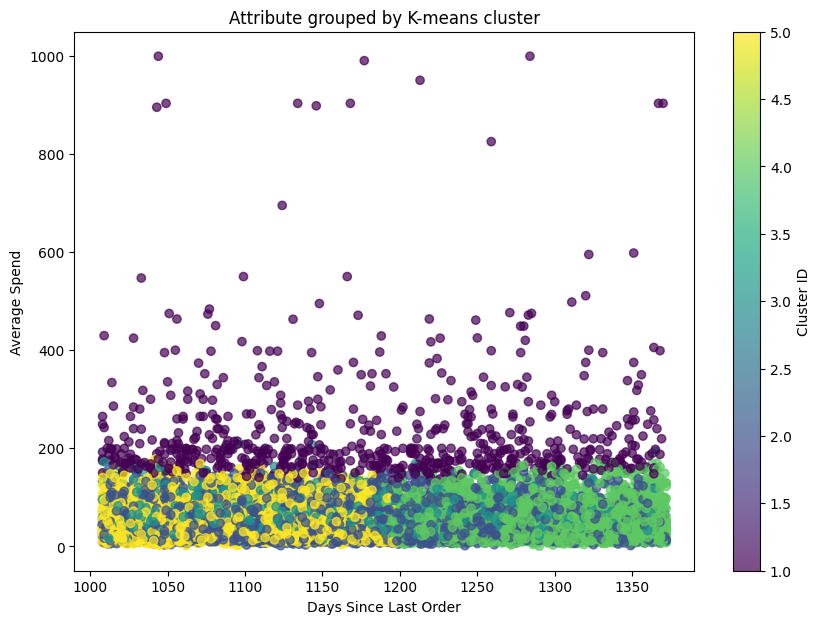

In [10]:
# prompt: 1. Using predictions_df, and matplotlib, generate a scatterplot. 2. On the x-axis of the scatterplot, display days_since_last_order and on the y-axis, display average_spend from predictions_df. 3. Color by cluster. 4. The chart should be titled "Attribute grouped by K-means cluster."

import matplotlib.pyplot as plt

# 1. Generate a scatterplot using predictions_df and matplotlib.
# 2. On the x-axis, display 'days_since_last_order' and on the y-axis, display 'average_spend'.
# 3. Color by cluster (CENTROID_ID).
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    predictions_df["days_since_last_order"].to_pandas(),
    predictions_df["average_spend"].to_pandas(),
    c=predictions_df["CENTROID_ID"].to_pandas(),
    cmap="viridis",
    alpha=0.7,
)

# Add labels and title
plt.xlabel("Days Since Last Order")
plt.ylabel("Average Spend")
plt.title("Attribute grouped by K-means cluster")

# Add a color bar to show the cluster mapping
plt.colorbar(scatter, label="Cluster ID")

# Display the plot
plt.show()

In [11]:
query = """
SELECT
 CONCAT('cluster ', CAST(centroid_id as STRING)) as centroid,
 average_spend,
 count_orders,
 days_since_last_order
FROM (
 SELECT centroid_id, feature, ROUND(numerical_value, 2) as value
 FROM ML.CENTROIDS(MODEL `{0}.{1}`)
)
PIVOT (
 SUM(value)
 FOR feature IN ('average_spend',  'count_orders', 'days_since_last_order')
)
ORDER BY centroid_id
""".format(dataset_name, model_name)

df_centroid = client.query(query).to_dataframe()
df_centroid.head()

,centroid,average_spend,count_orders,days_since_last_order
0,cluster 1,232.25,1.23,1180.76
1,cluster 2,47.33,1.27,1166.44
2,cluster 3,56.70,3.68,1143.15
3,cluster 4,50.13,1.32,1292.01
4,cluster 5,47.53,1.30,1092.97


In [12]:
df_query = client.query(query).to_dataframe()
df_query.to_string(header=False, index=False)

cluster_info = []
for i, row in df_query.iterrows():
 cluster_info.append("{0}, average spend ${2}, count of orders per person {1}, days since last order {3}"
  .format(row["centroid"], row["count_orders"], row["average_spend"], row["days_since_last_order"]) )

cluster_info = (str.join("\n", cluster_info))
print(cluster_info)

cluster 1, average spend $232.25, count of orders per person 1.23, days since last order 1180.76
cluster 2, average spend $47.33, count of orders per person 1.27, days since last order 1166.44
cluster 3, average spend $56.7, count of orders per person 3.68, days since last order 1143.15
cluster 4, average spend $50.13, count of orders per person 1.32, days since last order 1292.01
cluster 5, average spend $47.53, count of orders per person 1.3, days since last order 1092.97


In [13]:
#Generating the marketing campaign using the Gemini model
model = GenerativeModel("gemini-2.5-pro")

prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step. Identify the cluster number, the title of the person, a persona for them and the next marketing step.

Clusters:
{cluster_info}

For each Cluster:
* Title:
* Persona:
* Next marketing step:
"""

responses = model.generate_content(
   prompt,
   generation_config={
      "temperature": 0.1,
      "max_output_tokens": 4000,
      "top_p": 1.0,
      "top_k": 40,
   }
)

print(responses.text)

/usr/local/lib/python3.11/dist-packages/vertexai/generative_models/_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


Of course. As a creative brand strategist, my first observation is that all these clusters represent **lapsed customers**, with the average time since their last order being around 3 years (1092-1292 days). This is the most critical insight. Our entire strategy must be focused on **reactivation and winning them back**, not on nurturing existing relationships.

Here is the strategic breakdown for each cluster.

***

### **Cluster 3: The High-Priority Reactivation Target**

*(I'm starting with this cluster because it represents the highest potential ROI. These were once loyal customers.)*

*   **Title:** The Lost Loyalist
*   **Persona:** Meet **Chloe**. A few years ago, she was a fan of our brand. She didn't just buy once; she came back multiple times (3.68 orders). She appreciated the quality and consistency, and our brand was one of her go-to's for a specific need. However, life got in the way. Maybe a competitor caught her eye with a flashy offer, our product line didn't evolve with 

In [14]:
#To avoid incurring charges, you can delete the table and model used in this lab by running the following code in a new code cell within the notebook:
# Delete customer_stats table

client.delete_table(f"{project_id}.{dataset_name}.{table_name}", not_found_ok=True)
print(f"Deleted table: {project_id}.{dataset_name}.{table_name}")


# Delete K-means model
client.delete_model(f"{project_id}.{dataset_name}.{model_name}", not_found_ok=True)
print(f"Deleted model: {project_id}.{dataset_name}.{model_name}")

Deleted table: qwiklabs-gcp-03-cdf24d924f64.shaunak_ecommerce.customer_stats
Deleted model: qwiklabs-gcp-03-cdf24d924f64.shaunak_ecommerce.customer_segmentation_model
